In [ ]:
!pip install d2l==0.16.1

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn
import numpy as np

<font color = 'blue'>**CNN Model with Dropout Layer**

In [ ]:
class LeNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.5):
        super(LeNetWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

        self.dropout_rate = dropout


    def forward(self, x):
        return self.net(x)

<font color = 'blue'>**Training Function**

In [ ]:

def train_model(model, train_loader, loss_fn, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    return

<font color = 'blue'>**Evaluation Function**

In [ ]:

def evaluate_model(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

<font color = 'blue'>**Experiment function**

In [ ]:

def run_experiment(hparams, epochs, loss_fn, device, k):
    batch_size = 256
    k = k
    # Load dataset
    train_loader, test_loader = d2l.load_data_fashion_mnist(batch_size)


    # Original model
    original_model = LeNetWithDropout(**hparams).to(device)
    original_optimizer = torch.optim.Adam(original_model.parameters())

    # Training loop
    for epoch in range(epochs):
        train_model(original_model, train_loader, loss_fn, original_optimizer, device)

    # Evaluate the original model
    train_accuracy_original = evaluate_model(original_model, train_loader, device)
    test_accuracy_original = evaluate_model(original_model, test_loader, device)

    print("Train accuracy for original model is:", train_accuracy_original)
    print("Test accuracy for original model is:", test_accuracy_original)

    # K dropout models
    best_model = LeNetWithDropout(**hparams).to(device)
    best_accuracy = 0

    for epoch in range(epochs):
        models_and_performance = []

        for model_idx in range(k):
            current_model = LeNetWithDropout(**hparams).to(device)
            current_model.load_state_dict(best_model.state_dict())
            current_model.train()
            current_model.dropout_rate = torch.rand(1).item()

            optimizer = torch.optim.Adam(current_model.parameters())

            train_model(current_model, train_loader, loss_fn, optimizer, device)

            accuracy = evaluate_model(current_model, train_loader, device)

            models_and_performance.append((current_model, accuracy))

        best_model, best_accuracy = max(models_and_performance, key=lambda x: x[1])

       # print(f'Epoch {epoch + 1}/{epochs}, Best Model Validation Accuracy: {best_accuracy}, Dropout Rate: {best_model.dropout_rate}')

    train_accuracy = evaluate_model(best_model, train_loader, device)
    print(f"Train accuracy for {k} dropout mask model is:", train_accuracy)

    # Test the final model on the test set
    test_accuracy = evaluate_model(best_model, test_loader, device)
    print(f"Test accuracy for {k} dropout mask model is:", test_accuracy)

    train_accuracy_improvement = train_accuracy - train_accuracy_original
    test_accuracy_improvement = test_accuracy - test_accuracy_original

    return train_accuracy_improvement, test_accuracy_improvement

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**K=5**

In [ ]:

hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 5)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20


100%|██████████| 26421880/26421880 [00:01<00:00, 15886982.93it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275302.24it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5045610.81it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3708738.75it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train accuracy for original model is: 0.8089833333333334
Test accuracy for original model is: 0.7971
Train accuracy for 5 dropout mask model is: 0.8050333333333334
Test accuracy for 5 dropout mask model is: 0.7947

Running Experiment 2/20
Train accuracy for original model is: 0.8020833333333334
Test accuracy for original model is: 0.7908
Train accuracy for 5 dropout mask model is: 0.7980166666666667
Test accuracy for 5 dropout mask model is: 0.7879

Running Experiment 3/20
Train accuracy for original model is: 0.79845
Test accuracy for original model is: 0.7909
Train accuracy for 5 dropout mask model is: 0.8070166666666667
Test accuracy for 5 dropout mask model is: 0.7982

Running Experiment 4/20
Train accuracy for original model is: 0.7980666666666667
Test accuracy for original model is: 0.7877
Train accuracy for 5 dropout mask model is: 0.8037833333333333
Test accuracy for 5 dropout mask model is: 0.7942

Running Experiment 5/20
Train accuracy for original model is: 0.798566666666666

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)


Train accuracies improvement [-0.003950000000000009, -0.004066666666666663, 0.008566666666666722, 0.005716666666666592, 0.006433333333333402, -0.013066666666666671, 0.0010333333333333306, 0.003149999999999986, -0.004966666666666675, -0.009099999999999997, 0.00601666666666667, -0.0041999999999999815, 0.012249999999999983, -0.0026000000000000467, 0.00838333333333341, -0.007583333333333386, -0.008233333333333315, 0.0013333333333332975, -0.002650000000000041, 0.0020166666666666666]
Test accuracies improvement [-0.0024000000000000687, -0.0028999999999999027, 0.007299999999999973, 0.006500000000000061, 0.008199999999999985, -0.009499999999999953, -0.00040000000000006697, 9.999999999998899e-05, -0.006000000000000005, -0.00869999999999993, 0.006700000000000039, -0.00770000000000004, 0.008600000000000052, -0.0031999999999999806, 0.00770000000000004, -0.008700000000000041, -0.007199999999999984, -0.0037000000000000366, -0.0007000000000000339, 0.0036000000000000476]


<font color = 'blue'>**Box plots for train and test improvements**

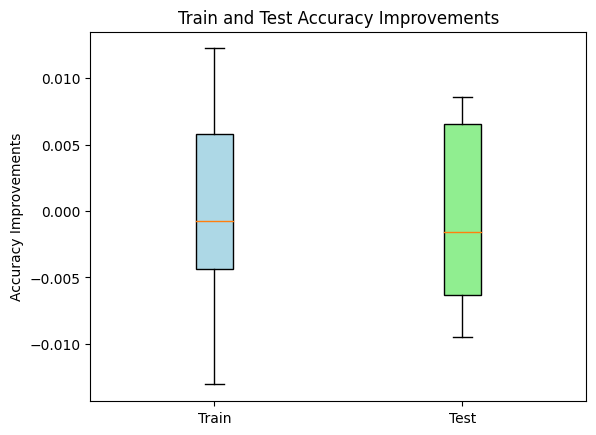

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**K=10**

In [ ]:

hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 10)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20


100%|██████████| 26421880/26421880 [00:02<00:00, 12549801.31it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211456.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3960205.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22421886.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train accuracy for original model is: 0.8053333333333333
Test accuracy for original model is: 0.791
Train accuracy for 10 dropout mask model is: 0.8061851851851852
Test accuracy for 10 dropout mask model is: 0.7966

Running Experiment 2/20
Train accuracy for original model is: 0.808
Test accuracy for original model is: 0.7921
Train accuracy for 10 dropout mask model is: 0.8047592592592593
Test accuracy for 10 dropout mask model is: 0.7916

Running Experiment 3/20
Train accuracy for original model is: 0.8020925925925926
Test accuracy for original model is: 0.7895
Train accuracy for 10 dropout mask model is: 0.7961296296296296
Test accuracy for 10 dropout mask model is: 0.7844

Running Experiment 4/20
Train accuracy for original model is: 0.8116851851851852
Test accuracy for original model is: 0.7985
Train accuracy for 10 dropout mask model is: 0.8206851851851852
Test accuracy for 10 dropout mask mod

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)


Train accuracies improvement [0.0008518518518518814, -0.0032407407407407662, -0.005962962962962948, 0.009000000000000008, -0.00794444444444442, -0.007222222222222241, -0.0154629629629629, 0.002981481481481474, -0.006629629629629652, -0.004148148148148123, -0.003277777777777713, -0.0012222222222222356, -0.009370370370370362, 0.012777777777777777, -0.0012407407407407645, 0.002685185185185124, 0.0020370370370370594, -0.0004074074074074119, -0.0052962962962963545, -0.004277777777777825]
Test accuracies improvement [0.005599999999999938, -0.000500000000000056, -0.005099999999999993, 0.009299999999999975, -0.007099999999999995, -0.0025999999999999357, -0.01540000000000008, 0.0013999999999999568, -0.005800000000000027, -0.0040999999999999925, -0.0040999999999999925, 0.00039999999999995595, -0.007900000000000018, 0.01100000000000001, -0.0008000000000000229, 0.0008000000000000229, 0.00039999999999995595, 0.0015999999999999348, -0.0045000000000000595, -0.005900000000000016]


<font color = 'blue'>**Box plots for train and test improvements**

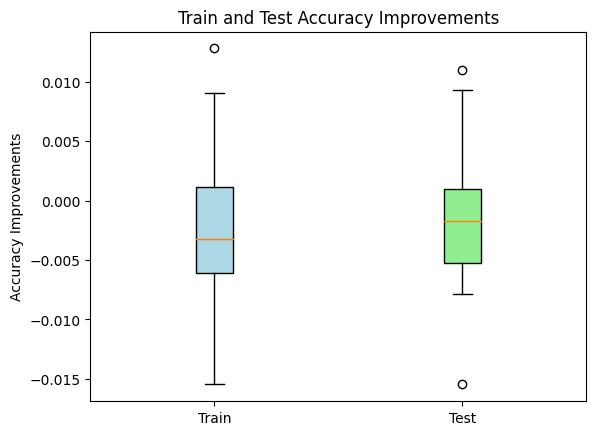

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()